# Global Settings

In [ ]:
#@title GLOBAL IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import os
import imutils
import random
import time
import shutil
from google.colab import drive
from shutil import copyfile

In [ ]:
#@title GLOBAL PARAMS

PARAMS = {
    'GLOBAL': {
        'aruco_folder': 'aruco'
    },
    'ARUCO_GEN': { # ArUco Generation Params
        'out_dir_name': 'original_aruco',
        'nr_of_aruco': 15,
        'type_of_aruco': 'DICT_4X4_1000',
        'aruco_width': 30,
        'aruco_height': 30,
        'aruco_border_size': 5 # ATT!! total dims: width=aruco_width + (2 * aruco_border_size), height=...
    },
    'ARUCO_TRANSF': { # Perspective Transformation Params
        'out_dir_name': 'edited_aruco',
        'nr_of_transformations': 5,
        'reduct_fact_width': 1/2,
        'reduct_fact_height': 2/7, #3/14
        'range_brightness_alpha': [1, 1] , # gain
        'range_brightness_beta': [-40, 100], # bias
    },
    'COCO_DATASET': { # COCO Dataset Params
        'imgs_dir_name': 'coco/images'
    },
    'IMAGE_OVERLAY': { # Image Overlay Params
        'dataset_path': 'dataset',
        'labels_path': 'labels',
        'imgs_path': 'images',
        'canny_threshold1': 10,
        'canny_threshold2': 100,
        'nr_of_imgs_for_aruco': 20,
        'range_images_size_width': [500, 700],
        'range_images_size_height': [500, 700]
    },
    'DRIVE': {
        'mount_drive_dir': '/content/drive',
        'dest_dir': 'MyDrive/TestColab'
    },
    'CUSTOM_DATABASE': {
        'database_directory': '/content/splitted_dataset',
        'perc_train': 70, # percentage of train set 
        'perc_val': 20, # percentage of val set 
        'perc_test': 10, # percentage of test set 
        'train_dir_name': 'train',
        'val_dir_name': 'val',
        'test_dir_name': 'test',


    }
}

# ArUco Generation in OpenCV

In [ ]:
#@title ArUco Generation PARAMETERS
name_of_directory = os.path.join(PARAMS['GLOBAL']['aruco_folder'], PARAMS['ARUCO_GEN']['out_dir_name'])
nr_of_aruco = PARAMS['ARUCO_GEN']['nr_of_aruco']
type_of_aruco = PARAMS['ARUCO_GEN']['type_of_aruco']
aruco_width = PARAMS['ARUCO_GEN']['aruco_width'] # in number of pixels
aruco_height = PARAMS['ARUCO_GEN']['aruco_height'] # in number of pixels
bordersize = PARAMS['ARUCO_GEN']['aruco_border_size'] # in number of pixels

## Code

In [ ]:
# define names of each possible ArUco tag OpenCV supports
ARUCO_DICT = {
	"DICT_4X4_50": cv2.aruco.DICT_4X4_50,
	"DICT_4X4_100": cv2.aruco.DICT_4X4_100,
	"DICT_4X4_250": cv2.aruco.DICT_4X4_250,
	"DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
	"DICT_5X5_50": cv2.aruco.DICT_5X5_50,
	"DICT_5X5_100": cv2.aruco.DICT_5X5_100,
	"DICT_5X5_250": cv2.aruco.DICT_5X5_250,
	"DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
	"DICT_6X6_50": cv2.aruco.DICT_6X6_50,
	"DICT_6X6_100": cv2.aruco.DICT_6X6_100,
	"DICT_6X6_250": cv2.aruco.DICT_6X6_250,
	"DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
	"DICT_7X7_50": cv2.aruco.DICT_7X7_50,
	"DICT_7X7_100": cv2.aruco.DICT_7X7_100,
	"DICT_7X7_250": cv2.aruco.DICT_7X7_250,
	"DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
	"DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
	"DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
	"DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
	"DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
	"DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
}

In [ ]:
!rm -R /content/aruco

rm: cannot remove '/content/aruco': No such file or directory


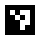

(40, 40)




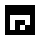

(40, 40)




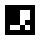

(40, 40)




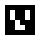

(40, 40)




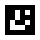

(40, 40)




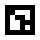

(40, 40)




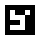

(40, 40)




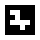

(40, 40)




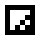

(40, 40)




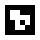

(40, 40)




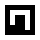

(40, 40)




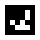

(40, 40)




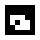

(40, 40)




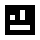

(40, 40)




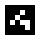

(40, 40)




In [ ]:
# create the output directory
Path(name_of_directory).mkdir(parents=True, exist_ok=True)

# load the ArUco dictionary
arucoDict = cv2.aruco.Dictionary_get(ARUCO_DICT[type_of_aruco])

for arucoID in range(nr_of_aruco):
  # allocate memory for the output ArUco tag
  tag = np.zeros((aruco_width, aruco_height, 1), dtype="uint8")
  # draw the ArUco tag on the output image
  cv2.aruco.drawMarker(arucoDict, arucoID, aruco_width, tag, 1)

  # add white border
  tag = cv2.copyMakeBorder(
    tag,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=[255, 255, 255]) 
  
  # write the generated ArUco tag to disk and then print it
  cv2.imwrite(os.path.join(name_of_directory, f'aruco_{arucoID:02d}.jpg'), tag)
  cv2_imshow(tag)
  print(tag.shape)
  print('\n')


# All ArUco Transformations

In [ ]:
#@title OpenCV Transformations PARAMETERS
out_dir = os.path.join(PARAMS['GLOBAL']['aruco_folder'], PARAMS['ARUCO_TRANSF']['out_dir_name'])
reduct_fact_width = PARAMS['ARUCO_TRANSF']['reduct_fact_width']
reduct_fact_height = PARAMS['ARUCO_TRANSF']['reduct_fact_height']
nr_of_transf = PARAMS['ARUCO_TRANSF']['nr_of_transformations']
range_brightness_alpha = PARAMS['ARUCO_TRANSF']['range_brightness_alpha']
range_brightness_beta = PARAMS['ARUCO_TRANSF']['range_brightness_beta']

In [ ]:
def perspective_transf(paper, reduct_fact_width, reduct_fact_height):
  # read the ArUco width and height
  paper_width, paper_height = paper.shape[:2]
  # print(paper.shape[:2])
  
  # set the size of the result image 
  # out_width, out_height = paper_width, paper_height #ALTERNATIVA
  out_width, out_height = paper_width + 10, paper_height + 10

  # set the coordinates that we want to perspective transform (the coords of the whole image)
  pts1 = np.float32([[0,0], [paper_width - 1 ,0], [paper_height - 1,paper_width - 1], [0, paper_height - 1]])

  # size of the transformed image
  new_width = round(paper_width * reduct_fact_width)
  new_height = round(paper_height * reduct_fact_height)

  # top left point
  # tl_point_x = 0 #ALTERNATIVA
  # tl_point_y = 0 #ALTERNATIVA
  tl_point_x = round((out_width - paper_width)/2)
  tl_point_y = round((out_height - paper_height)/2)
  tl_point = [tl_point_x, tl_point_y]
  # print(tl_point)

  # top right point
  tr_point_x = tl_point_x + (paper_width - 1)
  tr_point_y = tl_point_y
  tr_point = [tr_point_x, tr_point_y]
  # print(tr_point)

  # bottom left point
  bl_point_x = tl_point_x + (round((paper_width - new_width) / 2)) - 1
  bl_point_y = tl_point_y + (new_height - 1)
  bl_point = [bl_point_x, bl_point_y]
  # print(bl_point)

  # bottom right point
  br_point_x = bl_point_x + (new_width - 1)
  br_point_y = bl_point_y
  br_point = [br_point_x, br_point_y]
  # print(br_point)

  # edited_aruco = perspective_transf(original_aruco, np.float32([[10,20],[49,20],[39,35],[20,35]]))
  pts2 = np.float32([tl_point, tr_point, br_point, bl_point])
  # pts2 = np.float32([[4,4], [44,4], [34,13], [14,13]])
  # pts2 = np.float32([[0, 0], [39, 0],[15, 15],[35, 15]])


  # transformation matrix
  M = cv2.getPerspectiveTransform(pts1, pts2)
  # transform the original image
  return cv2.warpPerspective(paper, M, (out_width, out_height))


In [ ]:
!rm -R /content/aruco/edited_aruco/

rm: cannot remove '/content/aruco/edited_aruco/': No such file or directory


In [ ]:
def make_transf(orig_aruco, aruco_name, nr_of_transf, index):

  if nr_of_transf == 0:
    return
  else:
    # rotation transformation
    rotation_angle = random.randrange(0, 360)
    edited_aruco = imutils.rotate_bound(orig_aruco, rotation_angle)
    # print transformed image
    plt.title(f'Rotation transformation with angle={rotation_angle}')
    plt.imshow(edited_aruco, cmap='gray')
    plt.show()
    print('\n')
    # save the edited ArUco
    cv2.imwrite(os.path.join(out_dir_aruco, aruco_name[:-4] + '_' + f"{index:02}" + '.jpg'), edited_aruco)
    index += 1
    nr_of_transf -=1 

  if nr_of_transf == 0:
    return
  else:
    # random enable flip vertically and horizontally 
    if(bool(random.getrandbits(1))):
      edited_aruco = cv2.flip(edited_aruco, -1)
      # print transformed image
      plt.title(f'Flip vertically AND horizontally transformation')
      plt.imshow(edited_aruco, cmap='gray')
      plt.show()
      print('\n')
      # save the edited ArUco
      cv2.imwrite(os.path.join(out_dir_aruco, aruco_name[:-4] + '_' + f"{index:02}" + '.jpg'), edited_aruco)
      index += 1
      nr_of_transf -= 1    

  # if nr_of_transf == 0:
  #   return
  # else:
  #   # random enable brightness changes
  #   if(bool(random.getrandbits(1))):
  #     alpha = random.randint(range_brightness_alpha[0], range_brightness_alpha[1])
  #     beta = random.randint(range_brightness_beta[0], range_brightness_beta[1])
  #     edited_aruco = cv2.convertScaleAbs(edited_aruco, alpha=alpha, beta=beta)
  #     # print transformed image
  #     plt.title(f'Brightness transformation with alpha={alpha} and beta={beta}')
  #     plt.imshow(edited_aruco, cmap='gray')
  #     plt.show()
  #     print('\n')
  #     # save the edited ArUco
  #     cv2.imwrite(os.path.join(out_dir_aruco, aruco_name[:-4] + '_' + f"{index:02}" + '.jpg'), edited_aruco)
  #     index += 1
  #     nr_of_transf -= 1  

  if nr_of_transf == 0:
    return
  else:
    make_transf(orig_aruco, aruco_name, nr_of_transf, index)


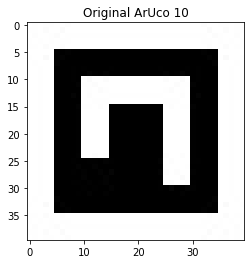

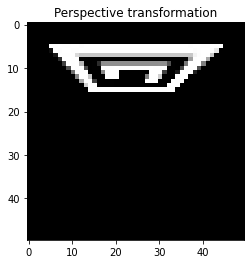

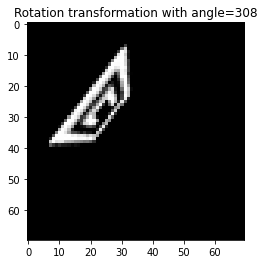

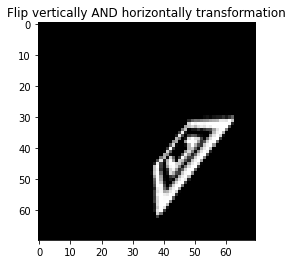

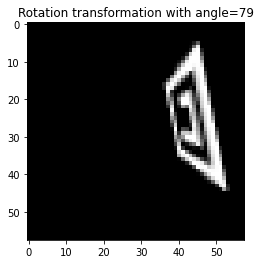

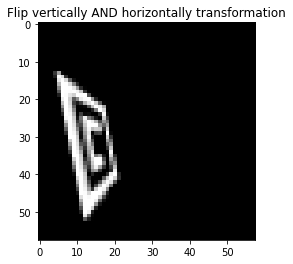

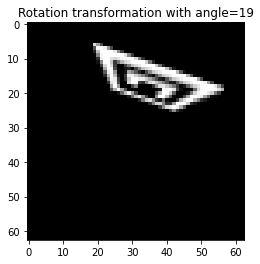

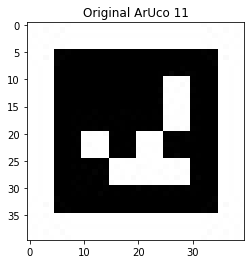

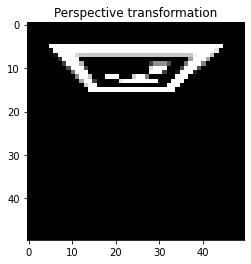

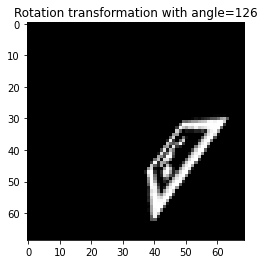

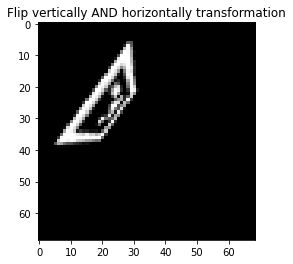

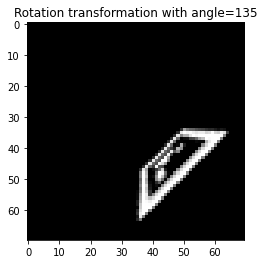

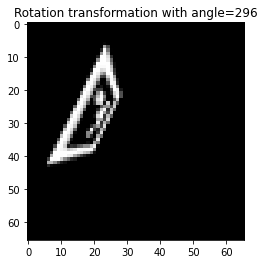

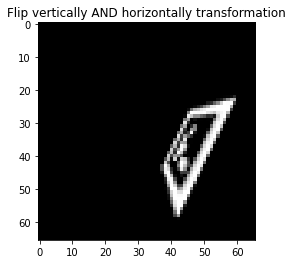

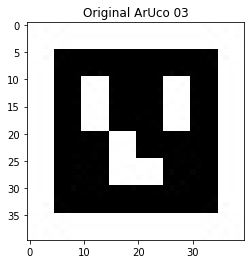

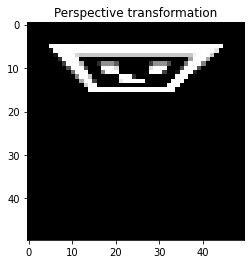

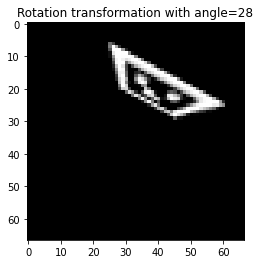

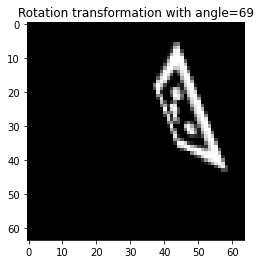

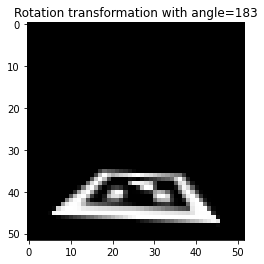

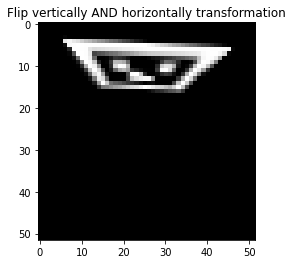

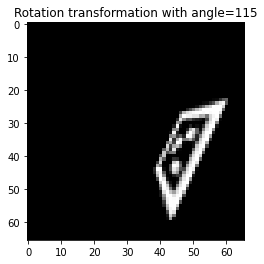

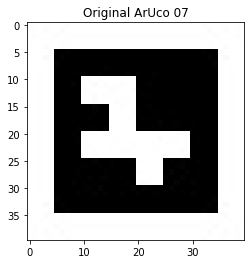

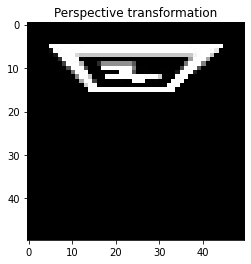

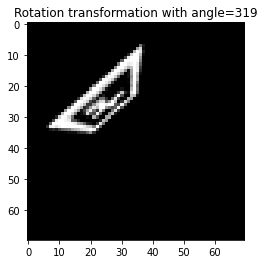

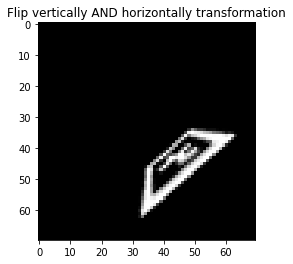

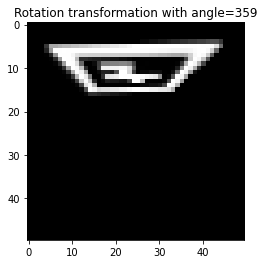

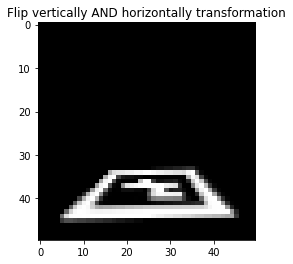

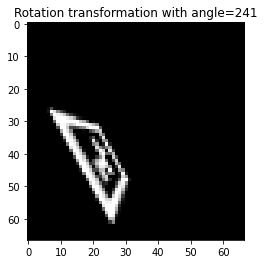

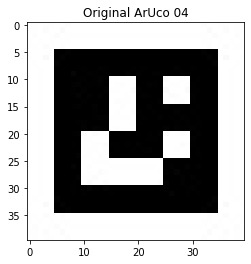

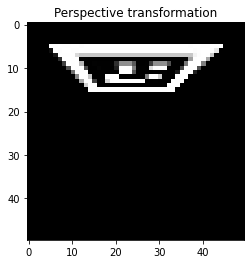

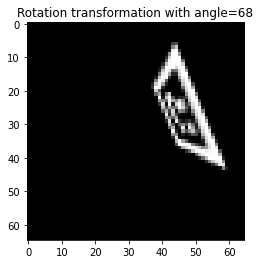

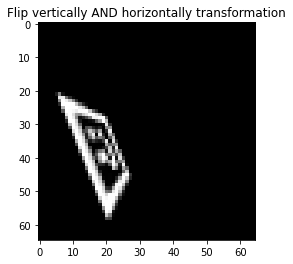

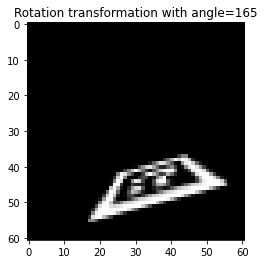

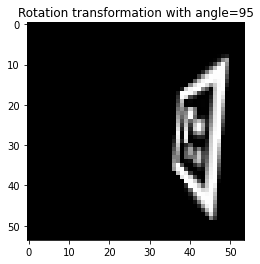

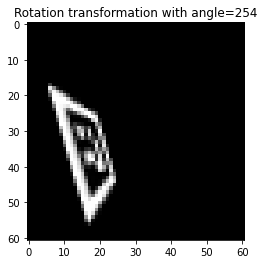

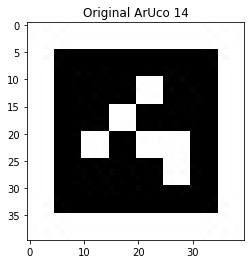

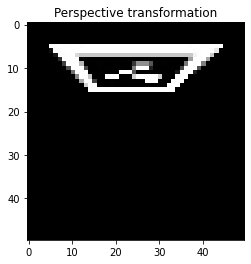

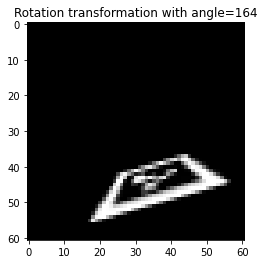

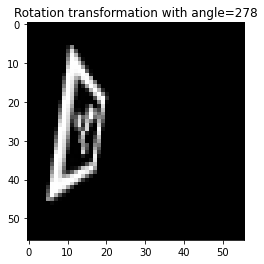

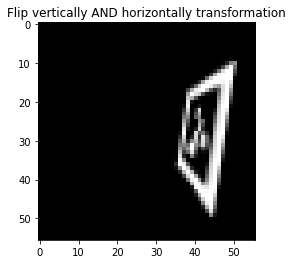

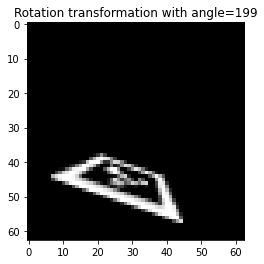

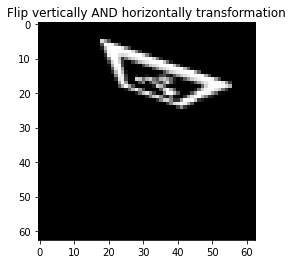

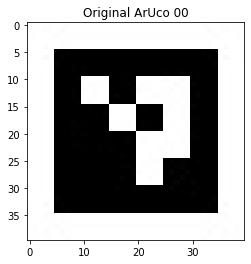

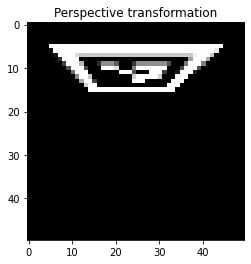

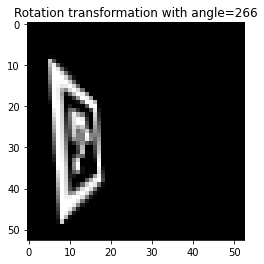

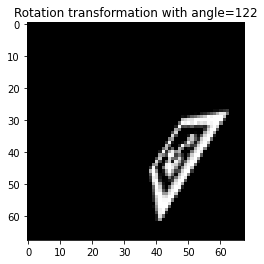

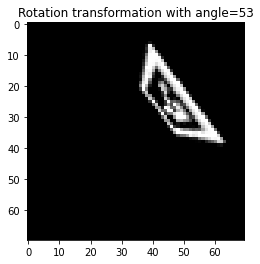

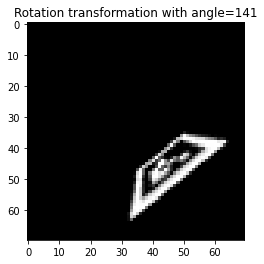

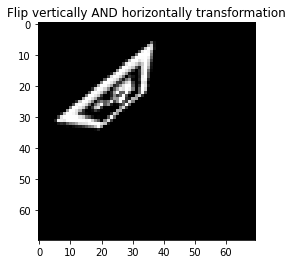

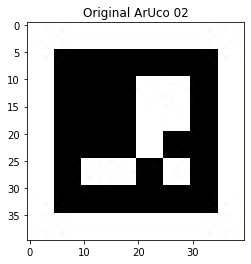

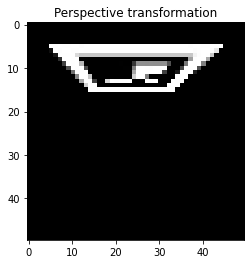

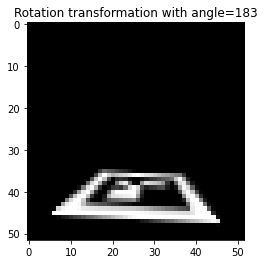

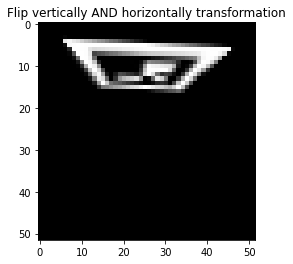

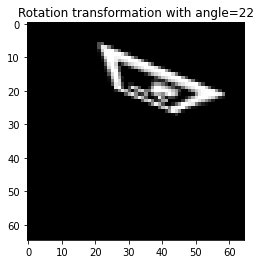

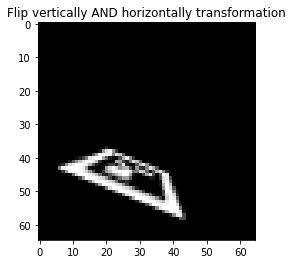

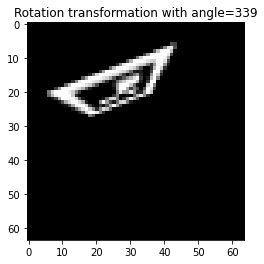

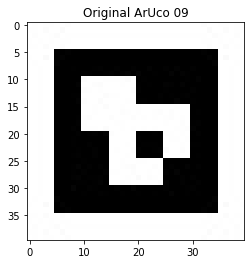

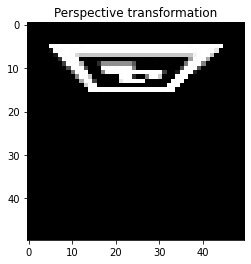

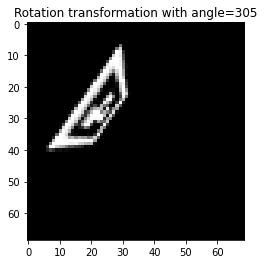

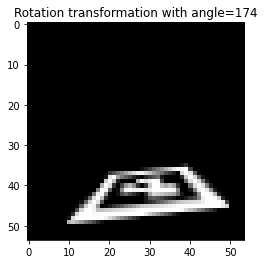

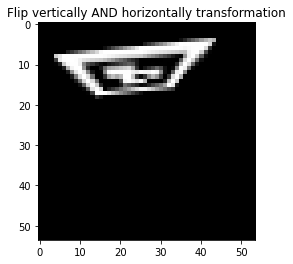

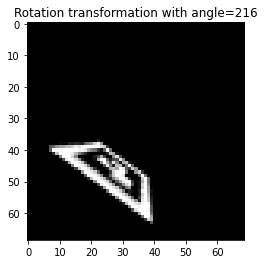

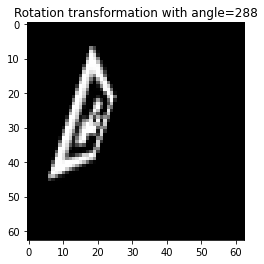

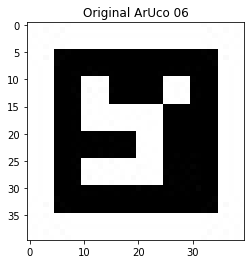

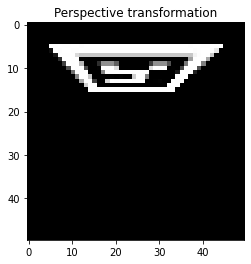

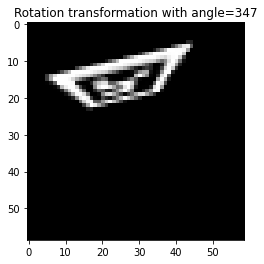

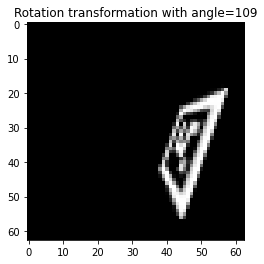

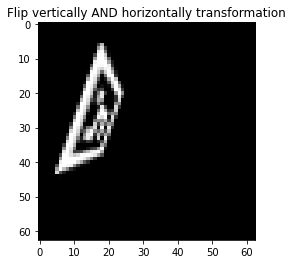

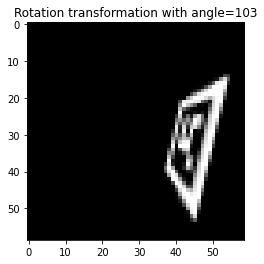

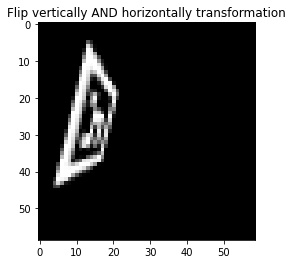

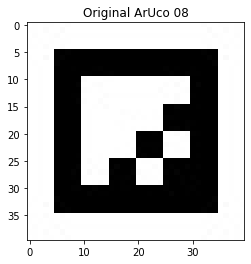

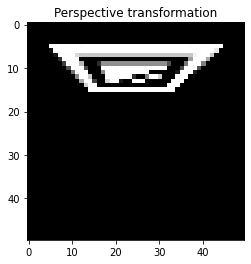

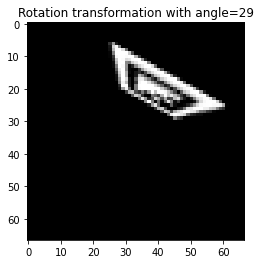

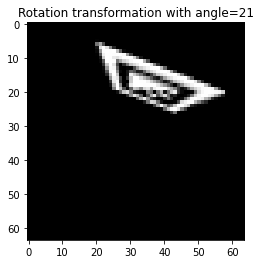

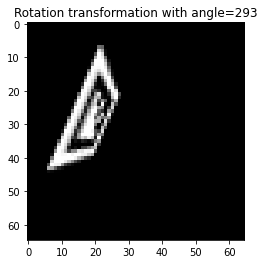

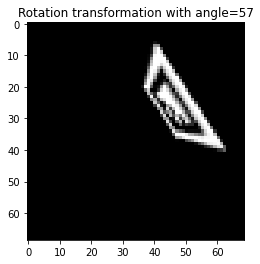

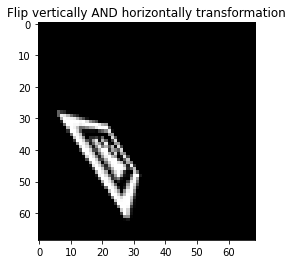

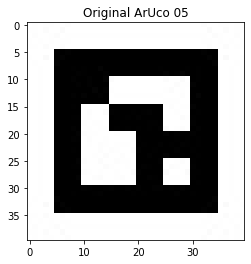

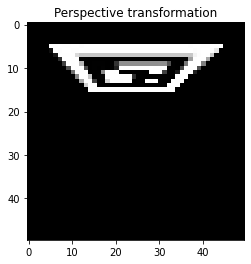

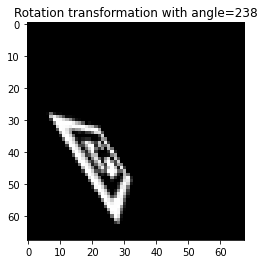

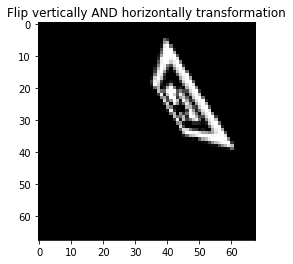

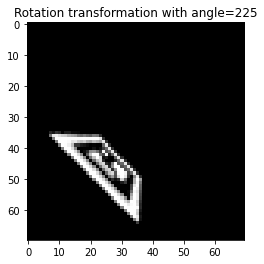

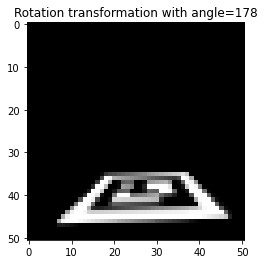

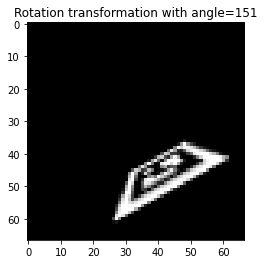

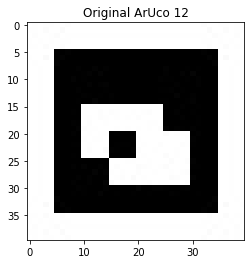

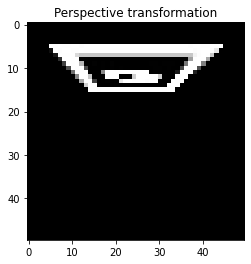

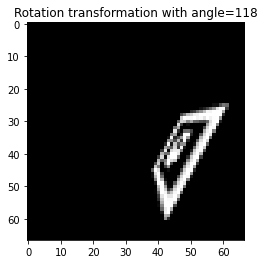

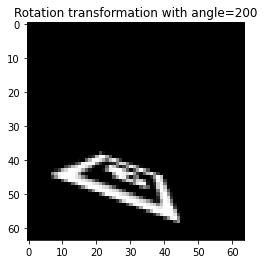

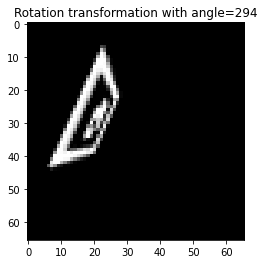

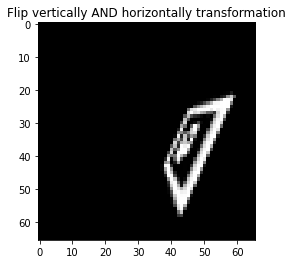

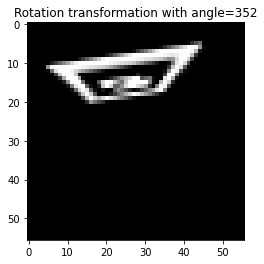

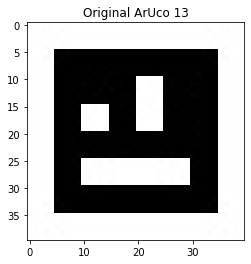

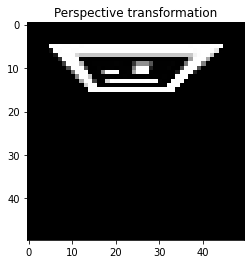

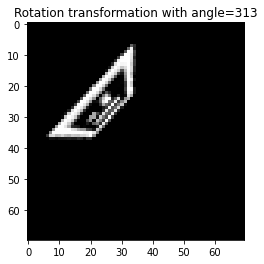

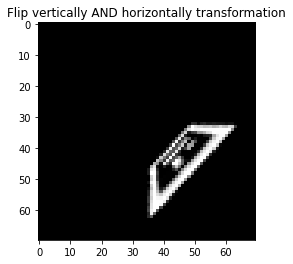

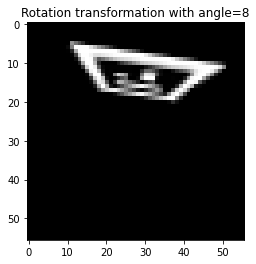

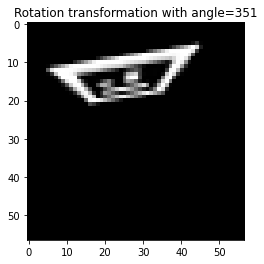

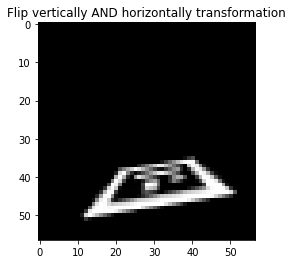

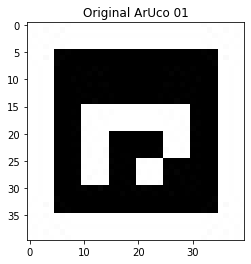

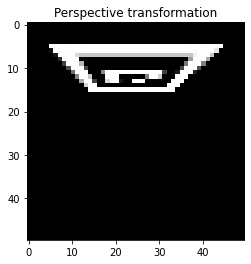

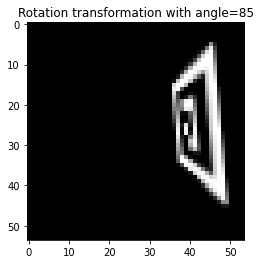

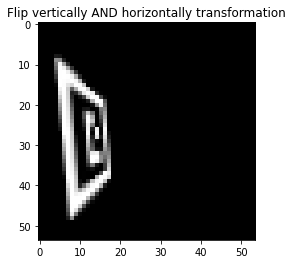

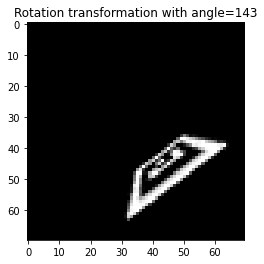

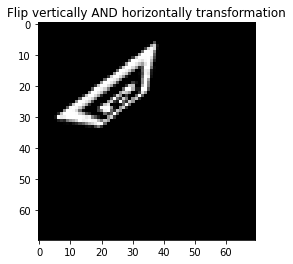

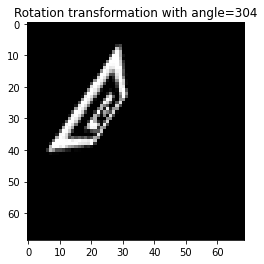

In [ ]:
Path(out_dir).mkdir(parents=True, exist_ok=True)
# read all ArUco filenames
aruco_list = [f for f in os.listdir(name_of_directory) if os.path.isfile(os.path.join(name_of_directory,f))]

# for each ArUco filename
for aruco_name in aruco_list:
  # create the output directory
  # Path(os.path.join(out_dir, aruco_name[:-4])).mkdir(parents=True, exist_ok=True)
  # out_dir_aruco = os.path.join(out_dir, aruco_name[:-4])
  out_dir_aruco = out_dir


  # read the ArUco
  original_aruco = cv2.imread(os.path.join(name_of_directory, aruco_name), cv2.IMREAD_GRAYSCALE)
  original_width, original_height = original_aruco.shape[:2]
  # print the original image
  plt.imshow(original_aruco, cmap='gray')
  plt.title(f'Original ArUco {aruco_name[-6:-4]}')
  plt.show()
  print('\n')

  # perspective transformation
  # edited_aruco = perspective_transf(original_aruco, np.float32([[10,20],[49,20],[39,35],[20,35]]))
  edited_aruco = perspective_transf(original_aruco, reduct_fact_width, reduct_fact_height)

  # print transformed image
  plt.title(f'Perspective transformation')
  plt.imshow(edited_aruco, cmap='gray')
  plt.show()
  print('\n')
  # save the edited ArUco
  cv2.imwrite(os.path.join(out_dir_aruco, aruco_name[:-4] + '_00.jpg'), edited_aruco)

  make_transf(edited_aruco, aruco_name, nr_of_transf, 1)



# Download COCO dataset

In [ ]:
#@title Download COCO dataset PARAMETERS
images_dir_name = PARAMS['COCO_DATASET']['imgs_dir_name']

### Download the COCO dataset images

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip

--2021-06-27 07:09:38--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.192.161
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.192.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  45.8MB/s    in 7m 22s  

2021-06-27 07:17:01 (41.7 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2021-06-27 07:17:01--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.141.236
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.141.236|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  41.4MB/s    in 18s     

2021-06-27 07:17:19 (43.5 MB/s) 

### Unzip downloaded zip files and remove them

In [ ]:
path = os.path.join('/content', images_dir_name)
Path(path).mkdir(parents=True, exist_ok=True)

!unzip /content/train2017.zip -d "$path"
!unzip /content/val2017.zip -d "$path"

!rm /content/train2017.zip
!rm /content/val2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: /content/coco/images/val2017/000000212226.jpg  
 extracting: /content/coco/images/val2017/000000231527.jpg  
 extracting: /content/coco/images/val2017/000000578922.jpg  
 extracting: /content/coco/images/val2017/000000062808.jpg  
 extracting: /content/coco/images/val2017/000000119038.jpg  
 extracting: /content/coco/images/val2017/000000114871.jpg  
 extracting: /content/coco/images/val2017/000000463918.jpg  
 extracting: /content/coco/images/val2017/000000365745.jpg  
 extracting: /content/coco/images/val2017/000000320425.jpg  
 extracting: /content/coco/images/val2017/000000481404.jpg  
 extracting: /content/coco/images/val2017/000000314294.jpg  
 extracting: /content/coco/images/val2017/000000335328.jpg  
 extracting: /content/coco/images/val2017/000000513688.jpg  
 extracting: /content/coco/images/val2017/000000158548.jpg  
 extracting: /content/coco/images/val2017/000000132116.jpg  
 extracting: /content/coco/images/

# All ArUco Overlay

In [ ]:
#@title Overlay PARAMETERS
dataset_path = PARAMS['IMAGE_OVERLAY']['dataset_path']
labels_path = PARAMS['IMAGE_OVERLAY']['labels_path']
imgs_path = PARAMS['IMAGE_OVERLAY']['imgs_path']
canny_thld1 = PARAMS['IMAGE_OVERLAY']['canny_threshold1'] # first threshold for the hysteresis procedure
canny_thld2 = PARAMS['IMAGE_OVERLAY']['canny_threshold2'] # second threshold for the hysteresis procedure
images_dir_name = PARAMS['COCO_DATASET']['imgs_dir_name']
nr_of_imgs_for_aruco = PARAMS['IMAGE_OVERLAY']['nr_of_imgs_for_aruco']
imgs_width_range = PARAMS['IMAGE_OVERLAY']['range_images_size_width']
imgs_height_range = PARAMS['IMAGE_OVERLAY']['range_images_size_height']

## Code

In [ ]:
# create the output directories
out_dir_imgs = os.path.join('/content', dataset_path, imgs_path)
Path(out_dir_imgs).mkdir(parents=True, exist_ok=True)

out_dir = os.path.join('/content', dataset_path, labels_path)
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
def write_label(min_x, min_y, max_x, max_y, img_filename, img, x, y, aruco_filename):

  # find center point, width and height of the bounding box
  x_center = (min_x + (max_x - min_x) / 2) + x
  y_center = (min_y + (max_y - min_y) / 2) + y
  width_BB = (max_x - min_x)
  height_BB = (max_y - min_y)

  # normalize box coordinates and center point
  x_center = x_center / img.shape[1]
  y_center = y_center / img.shape[0]
  width_BB = width_BB / img.shape[1]
  height_BB = height_BB / img.shape[0]

  # extract filename from the ArUco path
  aruco_filename = os.path.basename(aruco_filename)
  aruco_filename = os.path.splitext(aruco_filename)[0]

  # extract filename from the image path
  img_filename = os.path.basename(img_filename)
  img_filename = os.path.splitext(img_filename)[0]
  
  # save the label file
  out_dir_file = os.path.join(out_dir, os.path.basename(aruco_filename)[:8])

  Path(out_dir_file).mkdir(parents=True, exist_ok=True)
  with open(os.path.join(out_dir_file, img_filename + '.txt'), 'w') as f:
    f.write(f'{aruco_filename[-5:-3]} {x_center} {y_center} {width_BB} {height_BB}')

In [ ]:
def overlay_image_alpha(img, img_overlay, x, y, alpha_mask, img_filename, aruco_filename):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    np.set_printoptions(threshold=np.inf)
    alpha_inv = 1.0 - alpha
    # get the white pixels
    indices = np.where(alpha_inv == 0)

    # min x
    x_min = np.amin(indices[1])
    # min y
    y_min = np.amin(indices[0])

    # max x
    x_max = np.amax(indices[1])
    # max y
    y_max = np.amax(indices[0])

    # write the label
    write_label(x_min, y_min, x_max, y_max, img_filename, img, x, y, aruco_filename)

    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop

    # cv2.rectangle(img_crop,(x_min,y_min),(x_max,y_max),(0,255,0),1)

In [ ]:
def overlay(img_overlay_rgba, img, img_filename, aruco_filename):
  
  # ArUco width and height
  img_width, img_height = img_overlay_rgba.shape[:2]
  
  # overlay point (x, y)
  x, y = random.randint(0, img.shape[1] - img_width), random.randint(0, img.shape[0] - img_height)

  # crop the original image
  img_overlay_rgba = np.repeat(img_overlay_rgba.reshape((img_width, img_height, 1)), 4, axis=2)

  # Perform blending
  # alpha_mask = img_overlay_rgba[:, :, 1] / 255.0
  # cv2_imshow(alpha_mask)
  # img_result = img[:, :, :3].copy()
  # img_overlay = img_overlay_rgba[:, :, :3]
  # overlay_image_alpha(img_result, img_overlay, x, y, alpha_mask)

  # find edges in the ArUco image
  edges = cv2.Canny(img_overlay_rgba, canny_thld1, canny_thld2)
  edges = cv2.dilate(edges, None)
  edges = cv2.erode(edges, None)

  #-- Find contours in edges, sort by area ---------------------------------------------
  contour_info = []
  contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

  for c in contours:
      contour_info.append((
          c,
          cv2.isContourConvex(c),
          cv2.contourArea(c),
      ))
  contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)

  # create an empty mask
  mask = np.zeros(edges.shape)

  # draw filled polygon on it corresponding to largest contour (mask is black, polygon is white)
  for c in contour_info:
      cv2.fillConvexPoly(mask, c[0], (255))


  alpha_mask = mask / 255.0
  img_result = img[:, :, :3].copy()
  img_overlay = img_overlay_rgba[:, :, :3]



  overlay_image_alpha(img_result, img_overlay, x, y, alpha_mask, img_filename, aruco_filename)

  # show the result
  # plt.imshow(img_result)
  # plt.show()

  out_dir_aruco = os.path.join(out_dir_imgs, os.path.basename(aruco_filename)[:8])
  Path(out_dir_aruco).mkdir(parents=True, exist_ok=True)
  # save the result
  cv2.imwrite(os.path.join(out_dir_aruco, os.path.basename(img_filename)), cv2.cvtColor(img_result, cv2.COLOR_RGB2BGR))

In [ ]:
# read all ArUco filenames from the corresponding folder
name_of_directory = os.path.join(PARAMS['GLOBAL']['aruco_folder'], PARAMS['ARUCO_TRANSF']['out_dir_name'])
aruco_list = [f for f in os.listdir(name_of_directory) if os.path.isfile(os.path.join(name_of_directory,f))]

# read all images filenames from the corresponding folder
name_of_directory_imgs = os.path.join('/content', images_dir_name, 'train2017')
imgs_list = [f for f in os.listdir(name_of_directory_imgs) if os.path.isfile(os.path.join(name_of_directory_imgs,f))]

# # download the sample image
# !wget 'https://www.contentcustoms.com/assets/cms/uploads/images/New%20Images%20(Illustrations)/image-logo-design-services%20300x200.jpg' -O sample.jpg
# # open the image and create a NumPy array
# img = Image.open(os.path.join('/content', 'sample.jpg'))
# img_array = np.array(img)
# print(img_array.shape)

# print(len(aruco_list))
# print(len(imgs_list))

# for each ArUco filename make the overlay
for aruco_name in aruco_list:
  # read the ArUco image and create a NumPy array
  arucoImg = Image.open(os.path.join(name_of_directory, aruco_name))
  aruco = np.array(arucoImg)
  index = 0
  # print(f'CICLO ESTERNO - {aruco_name}')
  for image in imgs_list:
    # print(f'CICLO INTERNO - {image}')

    # open the image and create a NumPy array
    img = Image.open(os.path.join(name_of_directory_imgs, image))
    img_array = np.array(img)
    img_x, img_y = img_array.shape[:2]

    # remove the image from the images list
    imgs_list.remove(image)
    
    # if image width and height are not in specified range, continue with next image
    if img_x < imgs_width_range[0] or img_x > imgs_width_range[1] or img_y < imgs_height_range[0] or img_y > imgs_height_range[1]:
      continue

    # if the image is grayscale, continue with next image
    if len(img_array.shape)<3:
      continue

    # increment number of processed imgs for current ArUco
    index +=1

    # if the number of processed imgs is greater than specified number, switch to next ArUco
    if index > nr_of_imgs_for_aruco:
      break

    # make the overlay
    overlay(aruco, img_array, img.filename, arucoImg.filename)

# Splitted dataset

In [ ]:
#@title Splitted dataset PARAMETERS
perc_train = PARAMS['CUSTOM_DATABASE']['perc_train']
perc_valid = PARAMS['CUSTOM_DATABASE']['perc_val']
perc_test = PARAMS['CUSTOM_DATABASE']['perc_test']
db_dir = PARAMS['CUSTOM_DATABASE']['database_directory']
train_dir = PARAMS['CUSTOM_DATABASE']['train_dir_name']
val_dir = PARAMS['CUSTOM_DATABASE']['val_dir_name']
test_dir = PARAMS['CUSTOM_DATABASE']['test_dir_name']

## Code

In [ ]:
# create dirs

# imgs train dir
Path(os.path.join(db_dir, imgs_path, train_dir)).mkdir(parents=True, exist_ok=True)
# imgs val dir
Path(os.path.join(db_dir, imgs_path, val_dir)).mkdir(parents=True, exist_ok=True)
# imgs test dir
Path(os.path.join(db_dir, imgs_path, test_dir)).mkdir(parents=True, exist_ok=True)
# labels train dir
Path(os.path.join(db_dir, labels_path, train_dir)).mkdir(parents=True, exist_ok=True)
# labels val dir
Path(os.path.join(db_dir, labels_path, val_dir)).mkdir(parents=True, exist_ok=True)
# labels test dir
Path(os.path.join(db_dir, labels_path, test_dir)).mkdir(parents=True, exist_ok=True)

for aruco_dir in os.listdir(os.path.join('/content', dataset_path, imgs_path)):
  imgs_list = [f for f in os.listdir(os.path.join('/content', dataset_path, imgs_path, aruco_dir)) if os.path.isfile(os.path.join('/content', dataset_path, imgs_path, aruco_dir, f))]
  labels_list = [f for f in os.listdir(os.path.join('/content', dataset_path, labels_path, aruco_dir)) if os.path.isfile(os.path.join('/content', dataset_path, labels_path, aruco_dir, f))]

  # nr images for each ArUco
  nr_files = len(imgs_list)
  # nr images of train set
  nr_train = round((perc_train * nr_files) / 100)
  # nr of images of val set
  nr_valid = round((perc_valid * nr_files) / 100)
  # nr of images of test set
  nr_test = nr_files - nr_train - nr_valid

  # set of all images
  all_set = set(imgs_list)
  # remove extensions from image filenames
  all_set = set(x[:-4] for x in all_set) 
  # set of train images
  train = set(random.sample(all_set, nr_train))
  # set of val images
  val = set(random.sample(all_set - train, nr_valid))
  # set of test images
  test = all_set - train - val

  # insert each image in the right dir
  for image_filename in imgs_list:
    if image_filename[:-4] in train:
      copyfile(os.path.join('/content', dataset_path, imgs_path, aruco_dir, image_filename), os.path.join(db_dir, imgs_path, train_dir, image_filename))
    elif image_filename[:-4] in val:
      copyfile(os.path.join('/content', dataset_path, imgs_path, aruco_dir, image_filename), os.path.join(db_dir, imgs_path, val_dir, image_filename))
    elif image_filename[:-4] in test:
      copyfile(os.path.join('/content', dataset_path, imgs_path, aruco_dir, image_filename), os.path.join(db_dir, imgs_path, test_dir, image_filename))
    else: 
      raise ValueError(f'Image +++{image_filename[:-4]}+++ is not in train or val or test set.')

  # insert each label in the right dir
  for label_filename in labels_list:
    if label_filename[:-4] in train:
      copyfile(os.path.join('/content', dataset_path, labels_path, aruco_dir, label_filename), os.path.join(db_dir, labels_path, train_dir, label_filename))
    elif label_filename[:-4] in val:
      copyfile(os.path.join('/content', dataset_path, labels_path, aruco_dir, label_filename), os.path.join(db_dir, labels_path, val_dir, label_filename))
    elif label_filename[:-4] in test:
      copyfile(os.path.join('/content', dataset_path, labels_path, aruco_dir, label_filename), os.path.join(db_dir, labels_path, test_dir, label_filename))
    else: 
      raise ValueError(f'Label +++{label_filename[:-4]}+++ is not in train or val or test set.')

# Save dataset to Google Drive

In [ ]:
#@title Google Drive PARAMETERS
drive_mount_dir = PARAMS['DRIVE']['mount_drive_dir']
dest_dir = PARAMS['DRIVE']['dest_dir']
dataset_path = PARAMS['IMAGE_OVERLAY']['dataset_path']

## Code

In [ ]:
# mount Google Drive
drive.mount(drive_mount_dir)

dt = time.strftime("%Y_%m_%d_%H_%M")
dest = os.path.join(drive_mount_dir, dest_dir, dt) 

# save to Google Drive
shutil.copytree(db_dir, dest)

In [ ]:
# unmount Google Drive
drive.flush_and_unmount()